In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2539683/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 1y6ktp79


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-1y6ktp79:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                               | 0/330 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/330 [00:00<02:48,  1.96it/s]

  2%|█▊                                                                                                                     | 5/330 [00:00<00:31, 10.22it/s]

  3%|███▏                                                                                                                   | 9/330 [00:00<00:18, 17.27it/s]

  4%|█████                                                                                                                 | 14/330 [00:00<00:12, 24.66it/s]

  6%|██████▊                                                                                                               | 19/330 [00:00<00:10, 30.16it/s]

  7%|████████▌                                                                                                             | 24/330 [00:01<00:08, 34.13it/s]

  9%|██████████▎                                                                                                           | 29/330 [00:01<00:08, 37.00it/s]

 10%|████████████▏                                                                                                         | 34/330 [00:01<00:07, 39.10it/s]

 12%|█████████████▉                                                                                                        | 39/330 [00:01<00:07, 40.52it/s]

 13%|███████████████▋                                                                                                      | 44/330 [00:01<00:06, 41.53it/s]

 15%|█████████████████▌                                                                                                    | 49/330 [00:01<00:06, 42.25it/s]

 16%|███████████████████▎                                                                                                  | 54/330 [00:01<00:06, 42.81it/s]

 18%|█████████████████████                                                                                                 | 59/330 [00:01<00:06, 43.15it/s]

 19%|██████████████████████▉                                                                                               | 64/330 [00:01<00:06, 43.41it/s]

 21%|████████████████████████▋                                                                                             | 69/330 [00:02<00:05, 43.75it/s]

 22%|██████████████████████████▍                                                                                           | 74/330 [00:02<00:05, 43.88it/s]

 24%|████████████████████████████▏                                                                                         | 79/330 [00:02<00:05, 44.01it/s]

 25%|██████████████████████████████                                                                                        | 84/330 [00:02<00:05, 44.13it/s]

 27%|███████████████████████████████▊                                                                                      | 89/330 [00:02<00:05, 44.27it/s]

 28%|█████████████████████████████████▌                                                                                    | 94/330 [00:02<00:05, 44.28it/s]

 30%|███████████████████████████████████▍                                                                                  | 99/330 [00:02<00:05, 44.30it/s]

 32%|████████████████████████████████████▊                                                                                | 104/330 [00:02<00:05, 44.39it/s]

 33%|██████████████████████████████████████▋                                                                              | 109/330 [00:02<00:04, 44.35it/s]

 35%|████████████████████████████████████████▍                                                                            | 114/330 [00:03<00:04, 44.36it/s]

 36%|██████████████████████████████████████████▏                                                                          | 119/330 [00:03<00:04, 44.38it/s]

 38%|███████████████████████████████████████████▉                                                                         | 124/330 [00:03<00:04, 44.42it/s]

 39%|█████████████████████████████████████████████▋                                                                       | 129/330 [00:03<00:04, 44.42it/s]

 41%|███████████████████████████████████████████████▌                                                                     | 134/330 [00:03<00:04, 44.40it/s]

 42%|█████████████████████████████████████████████████▎                                                                   | 139/330 [00:03<00:04, 44.46it/s]

 44%|███████████████████████████████████████████████████                                                                  | 144/330 [00:03<00:04, 44.41it/s]

 45%|████████████████████████████████████████████████████▊                                                                | 149/330 [00:03<00:04, 44.39it/s]

 47%|██████████████████████████████████████████████████████▌                                                              | 154/330 [00:03<00:03, 44.37it/s]

 48%|████████████████████████████████████████████████████████▎                                                            | 159/330 [00:04<00:03, 44.41it/s]

 50%|██████████████████████████████████████████████████████████▏                                                          | 164/330 [00:04<00:03, 44.32it/s]

 51%|███████████████████████████████████████████████████████████▉                                                         | 169/330 [00:04<00:03, 44.22it/s]

 53%|█████████████████████████████████████████████████████████████▋                                                       | 174/330 [00:04<00:03, 44.18it/s]

 54%|███████████████████████████████████████████████████████████████▍                                                     | 179/330 [00:04<00:03, 44.10it/s]

 56%|█████████████████████████████████████████████████████████████████▏                                                   | 184/330 [00:04<00:03, 44.04it/s]

 57%|███████████████████████████████████████████████████████████████████                                                  | 189/330 [00:04<00:03, 44.01it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                                | 194/330 [00:04<00:03, 44.03it/s]

 60%|██████████████████████████████████████████████████████████████████████▌                                              | 199/330 [00:05<00:02, 43.99it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 204/330 [00:05<00:02, 43.99it/s]

 63%|██████████████████████████████████████████████████████████████████████████                                           | 209/330 [00:05<00:02, 43.99it/s]

 65%|███████████████████████████████████████████████████████████████████████████▊                                         | 214/330 [00:05<00:02, 44.06it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                       | 219/330 [00:05<00:02, 44.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▍                                     | 224/330 [00:05<00:02, 44.10it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 229/330 [00:05<00:02, 44.23it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 234/330 [00:05<00:02, 44.25it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▋                                | 239/330 [00:05<00:02, 44.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 244/330 [00:06<00:01, 44.13it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 249/330 [00:06<00:01, 44.11it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 254/330 [00:06<00:01, 44.02it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                         | 259/330 [00:06<00:01, 44.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 264/330 [00:06<00:01, 44.01it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 269/330 [00:06<00:01, 44.00it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 274/330 [00:06<00:01, 44.05it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 279/330 [00:06<00:01, 44.01it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 284/330 [00:06<00:01, 43.98it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 289/330 [00:07<00:00, 44.01it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 294/330 [00:07<00:00, 44.04it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████           | 299/330 [00:07<00:00, 44.02it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 304/330 [00:07<00:00, 44.01it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 309/330 [00:07<00:00, 44.05it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 314/330 [00:07<00:00, 44.00it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 319/330 [00:07<00:00, 43.96it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 324/330 [00:07<00:00, 43.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 329/330 [00:07<00:00, 43.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:08<00:00, 41.14it/s]

train - OK


  0%|                                                                                                                                | 0/42 [00:00<?, ?it/s]

  2%|██▊                                                                                                                     | 1/42 [00:00<00:04,  9.79it/s]

 14%|█████████████████▏                                                                                                      | 6/42 [00:00<00:01, 30.85it/s]

 26%|███████████████████████████████▏                                                                                       | 11/42 [00:00<00:00, 37.16it/s]

 38%|█████████████████████████████████████████████▎                                                                         | 16/42 [00:00<00:00, 40.02it/s]

 50%|███████████████████████████████████████████████████████████▌                                                           | 21/42 [00:00<00:00, 41.49it/s]

 62%|█████████████████████████████████████████████████████████████████████████▋                                             | 26/42 [00:00<00:00, 42.36it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▊                               | 31/42 [00:00<00:00, 42.94it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████                 | 36/42 [00:00<00:00, 43.38it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 41/42 [00:01<00:00, 43.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 38.94it/s]

val - OK


  0%|                                                                                                                                | 0/42 [00:00<?, ?it/s]

  2%|██▊                                                                                                                     | 1/42 [00:00<00:04,  8.86it/s]

 14%|█████████████████▏                                                                                                      | 6/42 [00:00<00:01, 29.20it/s]

 26%|███████████████████████████████▏                                                                                       | 11/42 [00:00<00:00, 35.63it/s]

 38%|█████████████████████████████████████████████▎                                                                         | 16/42 [00:00<00:00, 38.64it/s]

 50%|███████████████████████████████████████████████████████████▌                                                           | 21/42 [00:00<00:00, 40.32it/s]

 62%|█████████████████████████████████████████████████████████████████████████▋                                             | 26/42 [00:00<00:00, 41.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▊                               | 31/42 [00:00<00:00, 42.16it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████                 | 36/42 [00:00<00:00, 42.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 41/42 [00:01<00:00, 42.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 37.87it/s]

test InD - OK


  0%|                                                                                                                               | 0/340 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/340 [00:00<00:39,  8.68it/s]

  2%|██                                                                                                                     | 6/340 [00:00<00:11, 29.06it/s]

  3%|███▊                                                                                                                  | 11/340 [00:00<00:09, 35.69it/s]

  5%|█████▌                                                                                                                | 16/340 [00:00<00:08, 38.78it/s]

  6%|███████▎                                                                                                              | 21/340 [00:00<00:07, 40.45it/s]

  8%|█████████                                                                                                             | 26/340 [00:00<00:07, 41.43it/s]

  9%|██████████▊                                                                                                           | 31/340 [00:00<00:07, 42.07it/s]

 11%|████████████▍                                                                                                         | 36/340 [00:00<00:07, 42.48it/s]

 12%|██████████████▏                                                                                                       | 41/340 [00:01<00:06, 42.73it/s]

 14%|███████████████▉                                                                                                      | 46/340 [00:01<00:06, 42.92it/s]

 15%|█████████████████▋                                                                                                    | 51/340 [00:01<00:06, 43.04it/s]

 16%|███████████████████▍                                                                                                  | 56/340 [00:01<00:06, 43.13it/s]

 18%|█████████████████████▏                                                                                                | 61/340 [00:01<00:06, 43.22it/s]

 19%|██████████████████████▉                                                                                               | 66/340 [00:01<00:06, 43.26it/s]

 21%|████████████████████████▋                                                                                             | 71/340 [00:01<00:06, 43.28it/s]

 22%|██████████████████████████▍                                                                                           | 76/340 [00:01<00:06, 43.29it/s]

 24%|████████████████████████████                                                                                          | 81/340 [00:01<00:05, 43.32it/s]

 25%|█████████████████████████████▊                                                                                        | 86/340 [00:02<00:05, 43.34it/s]

 27%|███████████████████████████████▌                                                                                      | 91/340 [00:02<00:05, 43.35it/s]

 28%|█████████████████████████████████▎                                                                                    | 96/340 [00:02<00:05, 43.34it/s]

 30%|██████████████████████████████████▊                                                                                  | 101/340 [00:02<00:05, 43.35it/s]

 31%|████████████████████████████████████▍                                                                                | 106/340 [00:02<00:05, 43.34it/s]

 33%|██████████████████████████████████████▏                                                                              | 111/340 [00:02<00:05, 43.34it/s]

 34%|███████████████████████████████████████▉                                                                             | 116/340 [00:02<00:05, 43.36it/s]

 36%|█████████████████████████████████████████▋                                                                           | 121/340 [00:02<00:05, 43.35it/s]

 37%|███████████████████████████████████████████▎                                                                         | 126/340 [00:02<00:04, 43.35it/s]

 39%|█████████████████████████████████████████████                                                                        | 131/340 [00:03<00:04, 43.37it/s]

 40%|██████████████████████████████████████████████▊                                                                      | 136/340 [00:03<00:04, 43.37it/s]

 41%|████████████████████████████████████████████████▌                                                                    | 141/340 [00:03<00:04, 43.37it/s]

 43%|██████████████████████████████████████████████████▏                                                                  | 146/340 [00:03<00:04, 43.22it/s]

 44%|███████████████████████████████████████████████████▉                                                                 | 151/340 [00:03<00:04, 43.23it/s]

 46%|█████████████████████████████████████████████████████▋                                                               | 156/340 [00:03<00:04, 43.22it/s]

 47%|███████████████████████████████████████████████████████▍                                                             | 161/340 [00:03<00:04, 43.27it/s]

 49%|█████████████████████████████████████████████████████████                                                            | 166/340 [00:03<00:04, 43.31it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 171/340 [00:04<00:03, 43.33it/s]

 52%|████████████████████████████████████████████████████████████▌                                                        | 176/340 [00:04<00:03, 43.29it/s]

 53%|██████████████████████████████████████████████████████████████▎                                                      | 181/340 [00:04<00:03, 43.30it/s]

 55%|████████████████████████████████████████████████████████████████                                                     | 186/340 [00:04<00:03, 43.32it/s]

 56%|█████████████████████████████████████████████████████████████████▋                                                   | 191/340 [00:04<00:03, 43.34it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                 | 196/340 [00:04<00:03, 43.31it/s]

 59%|█████████████████████████████████████████████████████████████████████▏                                               | 201/340 [00:04<00:03, 43.31it/s]

 61%|██████████████████████████████████████████████████████████████████████▉                                              | 206/340 [00:04<00:03, 43.34it/s]

 62%|████████████████████████████████████████████████████████████████████████▌                                            | 211/340 [00:04<00:02, 43.35it/s]

 64%|██████████████████████████████████████████████████████████████████████████▎                                          | 216/340 [00:05<00:02, 43.36it/s]

 65%|████████████████████████████████████████████████████████████████████████████                                         | 221/340 [00:05<00:02, 43.31it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▊                                       | 226/340 [00:05<00:02, 43.33it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▍                                     | 231/340 [00:05<00:02, 43.34it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 236/340 [00:05<00:02, 43.43it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 241/340 [00:05<00:02, 43.50it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▋                                | 246/340 [00:05<00:02, 43.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                              | 251/340 [00:05<00:02, 43.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████                             | 256/340 [00:05<00:01, 43.58it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                           | 261/340 [00:06<00:01, 43.60it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 266/340 [00:06<00:01, 43.63it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                       | 271/340 [00:06<00:01, 43.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▉                      | 276/340 [00:06<00:01, 43.65it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 281/340 [00:06<00:01, 43.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 286/340 [00:06<00:01, 43.64it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 291/340 [00:06<00:01, 43.67it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 296/340 [00:06<00:01, 43.65it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 301/340 [00:07<00:00, 43.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 306/340 [00:07<00:00, 43.65it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████          | 311/340 [00:07<00:00, 43.66it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 316/340 [00:07<00:00, 43.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 321/340 [00:07<00:00, 43.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 326/340 [00:07<00:00, 43.65it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 331/340 [00:07<00:00, 43.64it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 336/340 [00:07<00:00, 43.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:07<00:00, 42.72it/s]

test OoD - OK


  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

  5%|█████▉                                                                                                                 | 5/100 [00:00<00:02, 44.88it/s]

 10%|███████████▊                                                                                                          | 10/100 [00:00<00:02, 44.99it/s]

 15%|█████████████████▋                                                                                                    | 15/100 [00:00<00:01, 45.06it/s]

 20%|███████████████████████▌                                                                                              | 20/100 [00:00<00:01, 45.13it/s]

 25%|█████████████████████████████▌                                                                                        | 25/100 [00:00<00:01, 45.16it/s]

 30%|███████████████████████████████████▍                                                                                  | 30/100 [00:00<00:01, 45.19it/s]

 35%|█████████████████████████████████████████▎                                                                            | 35/100 [00:00<00:01, 45.20it/s]

 40%|███████████████████████████████████████████████▏                                                                      | 40/100 [00:00<00:01, 45.21it/s]

 45%|█████████████████████████████████████████████████████                                                                 | 45/100 [00:00<00:01, 45.23it/s]

 50%|███████████████████████████████████████████████████████████                                                           | 50/100 [00:01<00:01, 45.24it/s]

 55%|████████████████████████████████████████████████████████████████▉                                                     | 55/100 [00:01<00:00, 45.25it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 60/100 [00:01<00:00, 45.25it/s]

 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 65/100 [00:01<00:00, 45.25it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 70/100 [00:01<00:00, 45.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 75/100 [00:01<00:00, 45.26it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 80/100 [00:01<00:00, 45.26it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 85/100 [00:01<00:00, 45.24it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 90/100 [00:01<00:00, 45.25it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 95/100 [00:02<00:00, 45.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.20it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153, 2) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269, 2) (5269,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 2) (5270,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 2) (43520,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


In [11]:
# create tsne embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5270, 2) (43520, 2)
(5270, 2) (43520, 2)


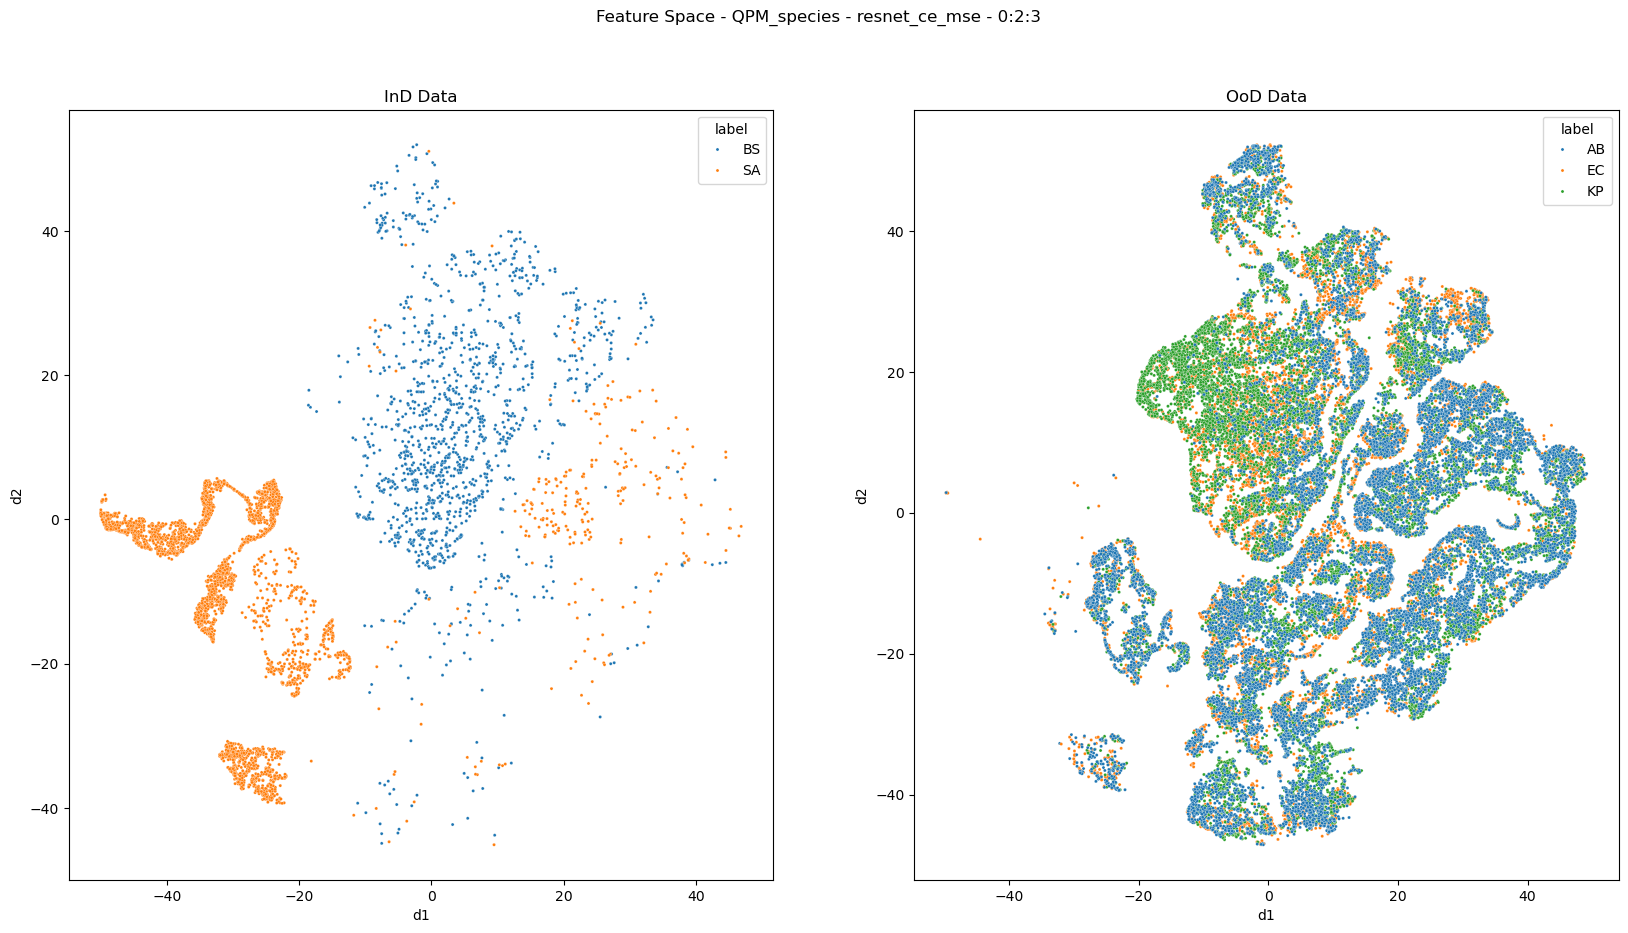

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

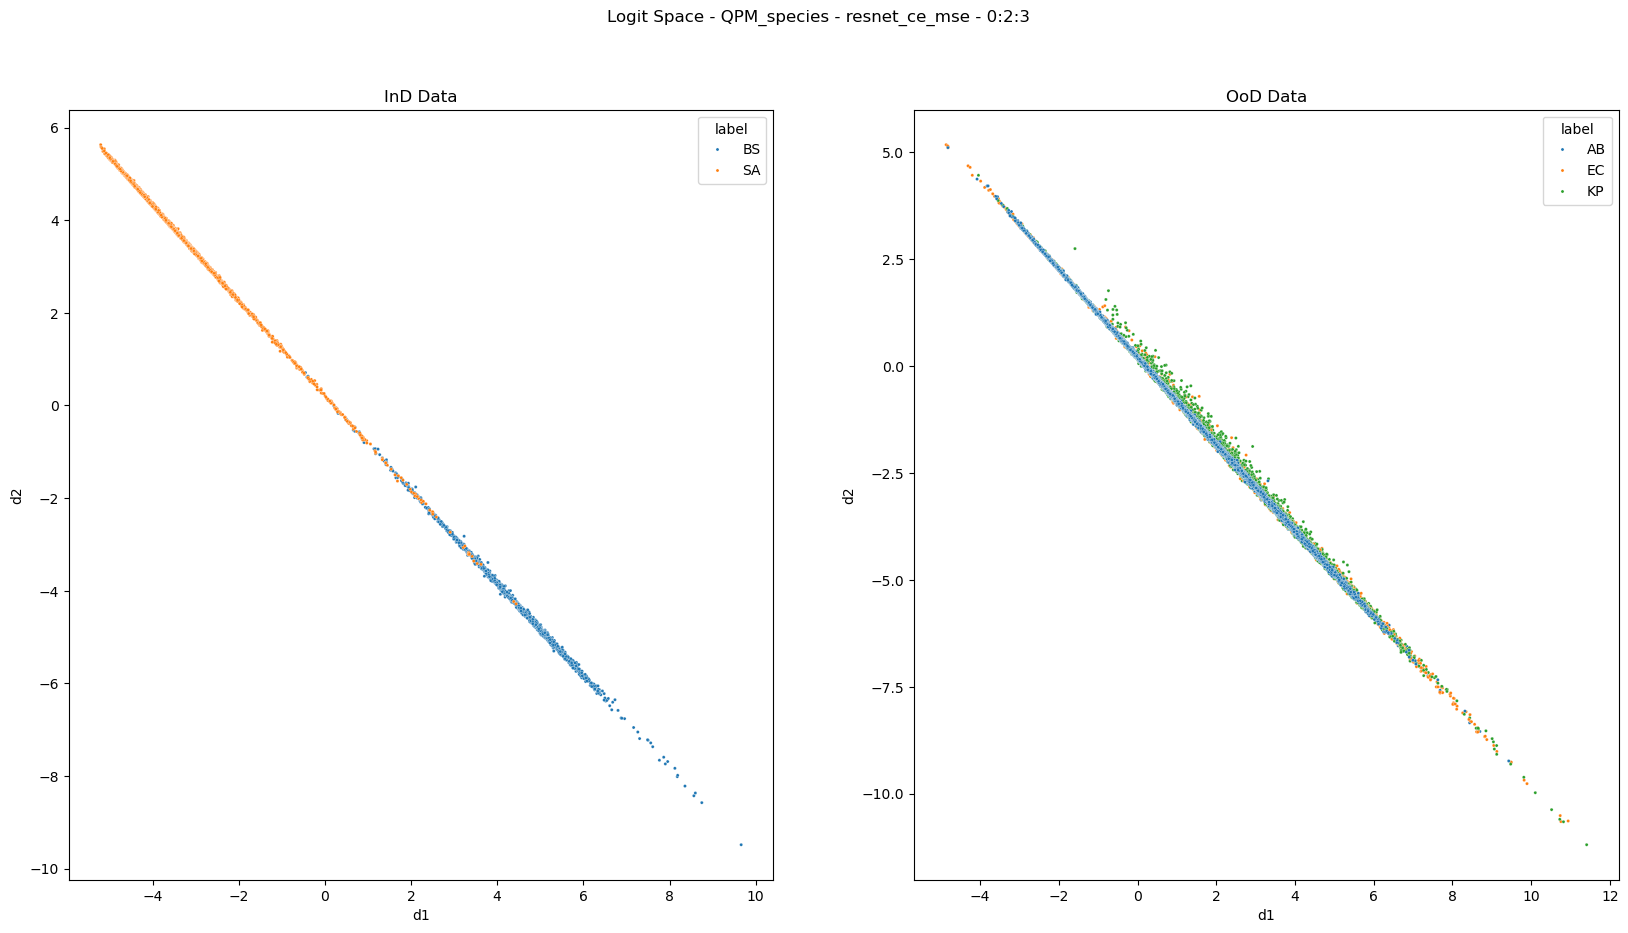

In [13]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:02<00:06,  2.05s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:04<00:03,  1.99s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:06<00:02,  2.01s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.09s/it]

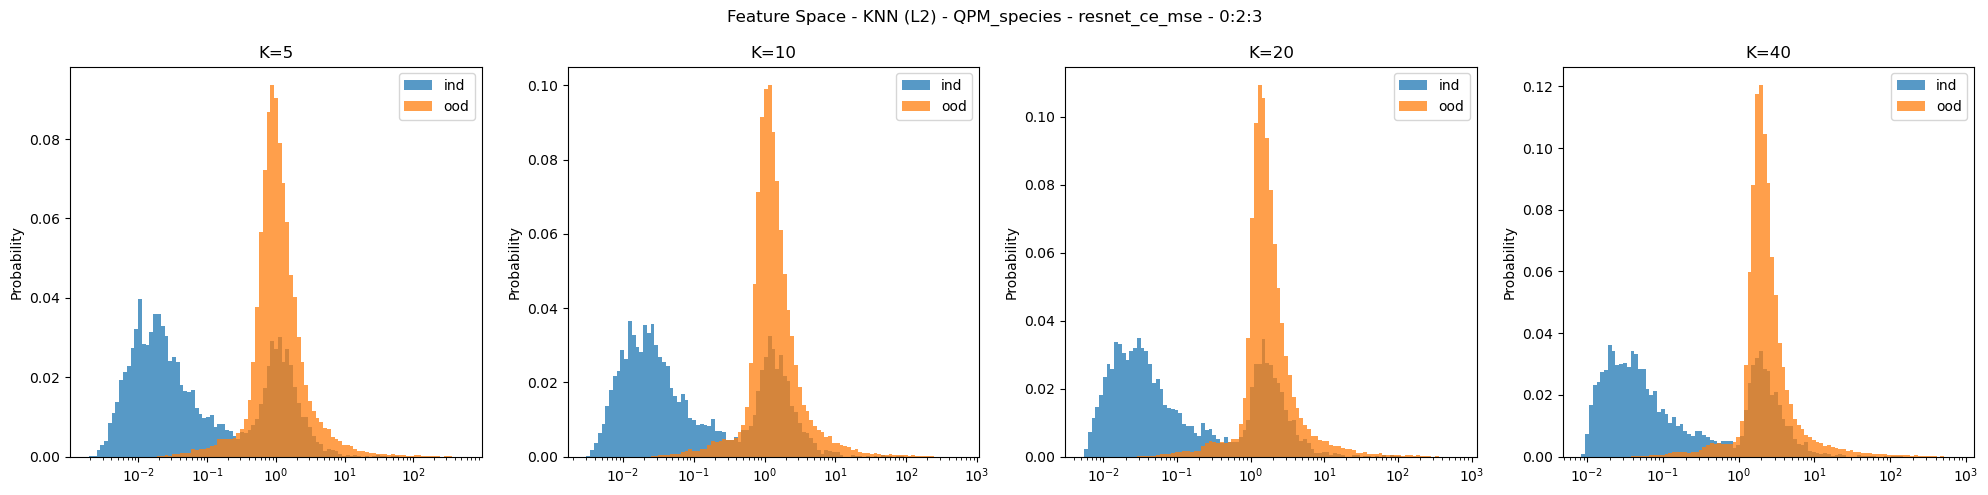

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:01<00:05,  1.84s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:03<00:03,  1.94s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:05<00:01,  1.94s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  2.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.99s/it]

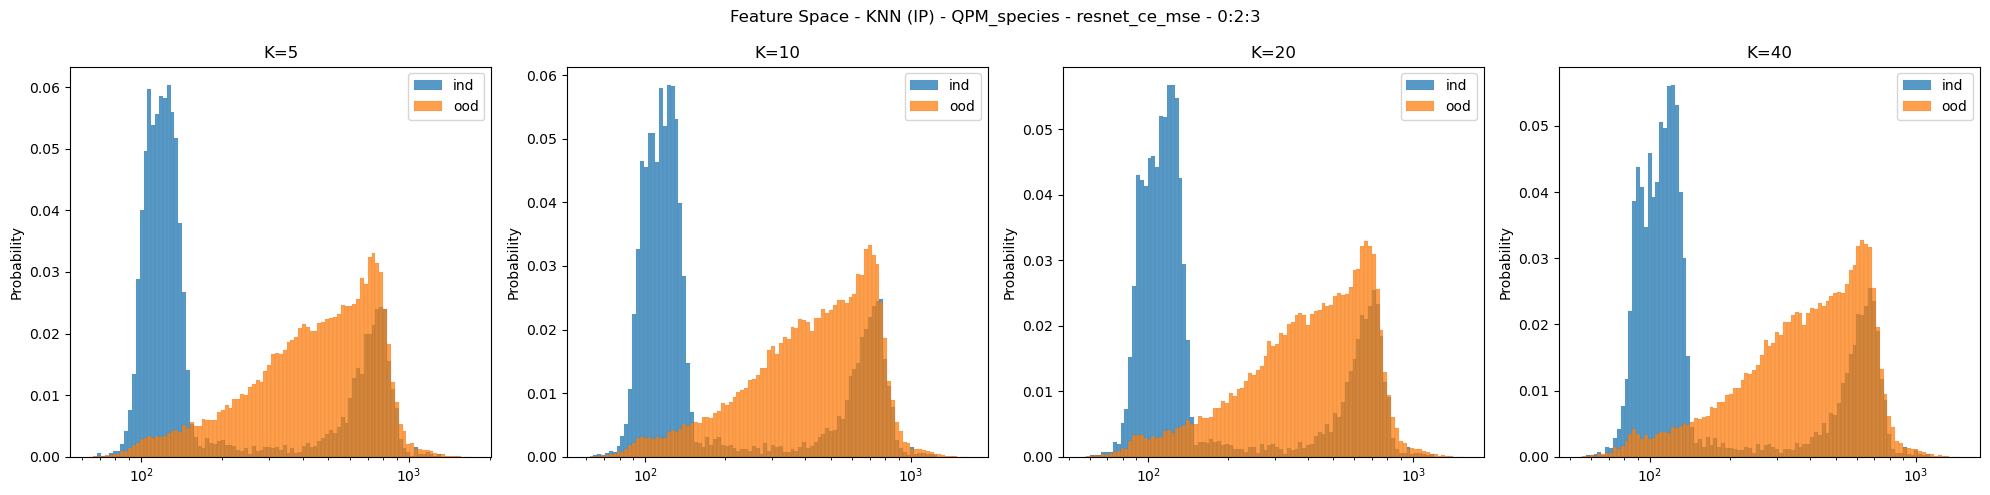

In [15]:
# plot knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:01,  2.69it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  2.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:01<00:00,  2.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]

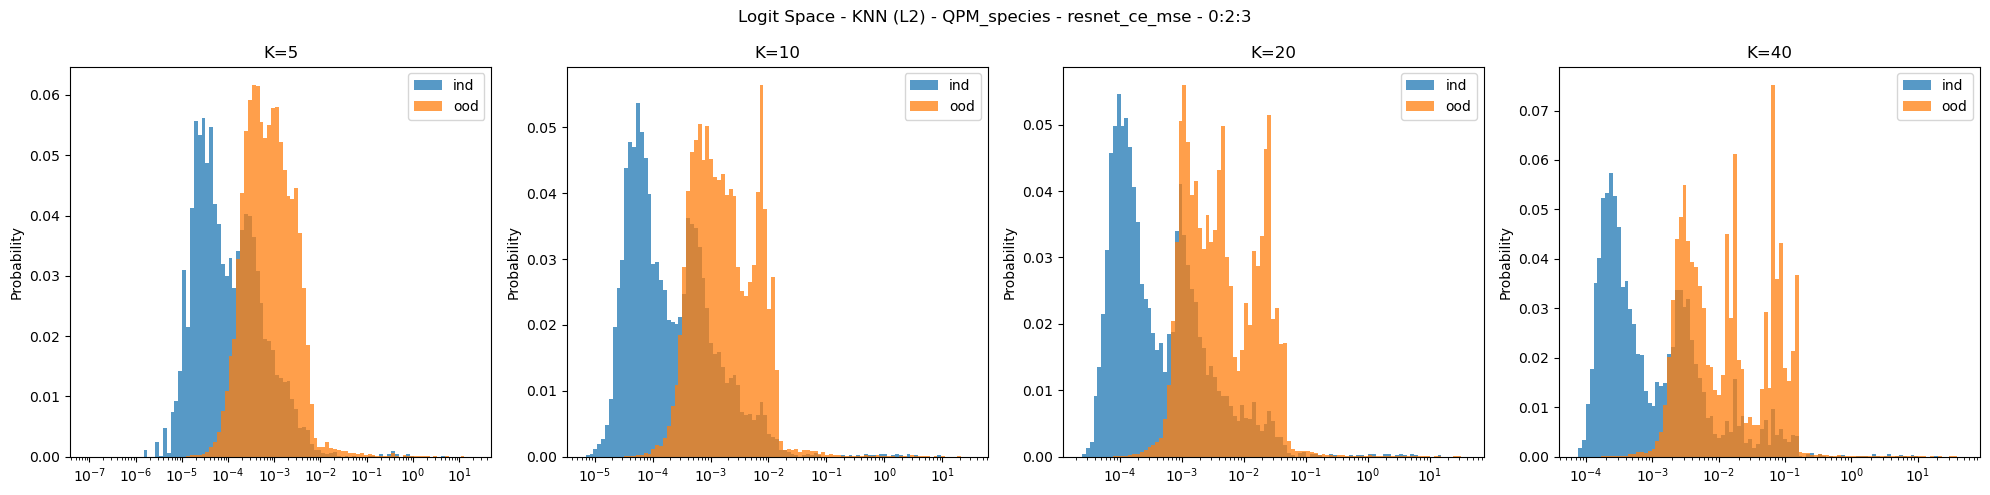

In [16]:
# plot knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  3.06it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  3.01it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:01<00:00,  2.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]

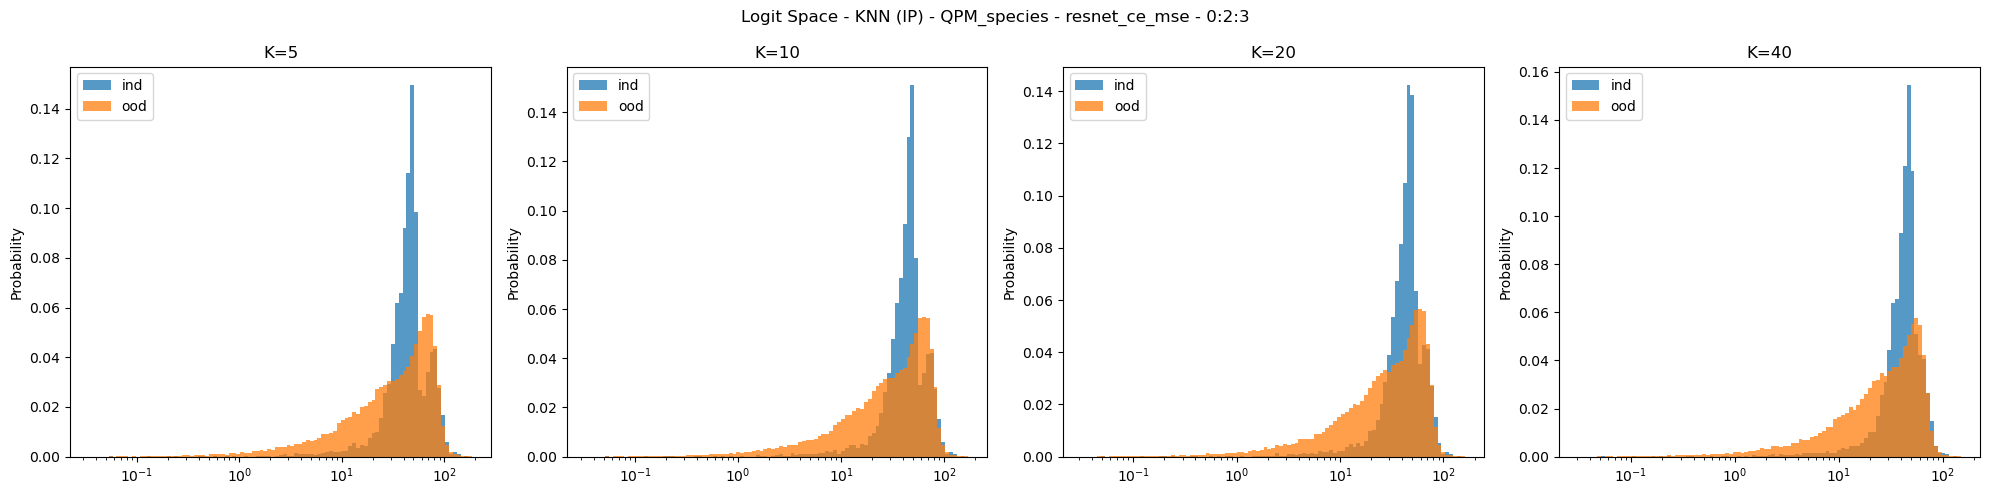

In [17]:
# plot knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

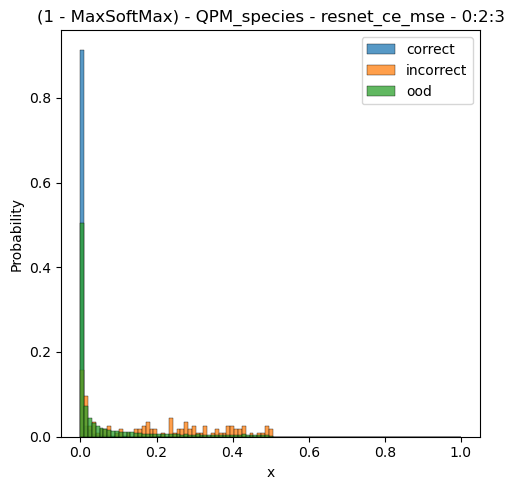

In [18]:
# plot (1 - maxsoftmax) distribution
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

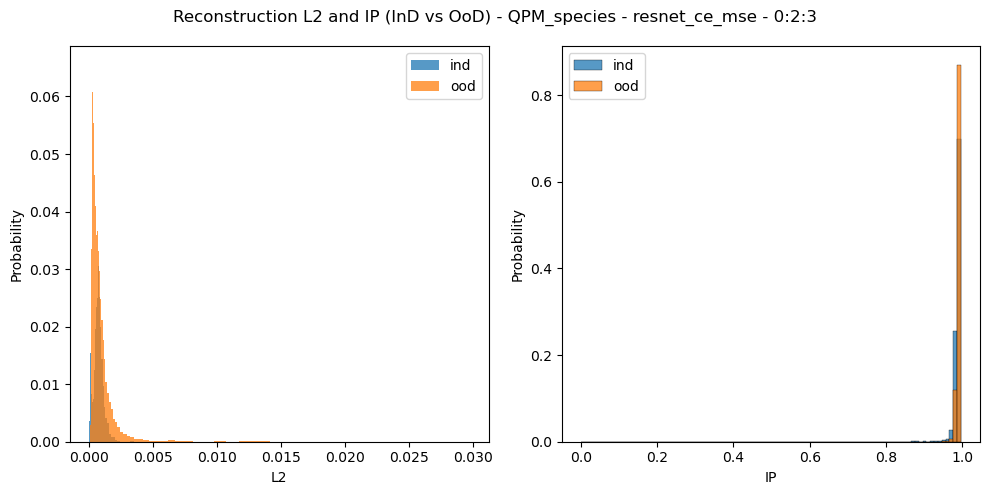

In [19]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()